# Replication of Wavenet in Pytorch for Character-Level Prediction Model

paper: https://arxiv.org/abs/1609.03499

In [88]:
%reset -f
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
import torch
import torch.nn.functional as F
import seaborn as sns
import random
from methods import Linear, Tanh, BatchNorm1D, Embedding, Flatten, Sequential

### Loading Data and Configs

In [90]:
# reading names from input file

names = open('names.txt', mode='r').read().splitlines()

type(names), len(names), names[0:3]

(list, 32033, ['emma', 'olivia', 'ava'])

In [91]:
# defining constants and hyper-parameters

START_END_CH = '.'
NUM_OF_PREV_CHAR_TO_USE = 8
EMBEDDING_DIM = 10
TRAIN_VALIDATION_TEST_SPLIT = (0.8, 0.1, 0.1)
NUMBER_OF_NEURONS = 68 # how many nodes in the hidden layer?
BATCH_SIZE = 32


g = torch.Generator().manual_seed(2147483647)
random.seed(42)
torch.manual_seed(42)

In [92]:
# creating a lookup between characters to alphabet index, and vice versa

stoi = {ch: (i+1) for i, ch in enumerate(sorted(set(''.join(names))))}
stoi[START_END_CH] = 0
itos = {i: ch for ch, i in stoi.items()}

# useful additional constant
VOCAB_SIZE = len(stoi.items())

print(stoi)
print(VOCAB_SIZE)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
27


In [93]:
# building X and Y dataset: train, validation, and test splits

def get_X_and_Y(names, print_examples=False):
    X, Y = [], []
    for n in names:
        block = [0] * NUM_OF_PREV_CHAR_TO_USE
        for ch in n + '.':
            ix = stoi[ch]
            X.append(block)
            Y.append(ix)
            block = [*block[1:], ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y


random.shuffle(names)
n1 = int(len(names) * TRAIN_VALIDATION_TEST_SPLIT[0])
n2 = int(len(names) *
         (TRAIN_VALIDATION_TEST_SPLIT[0] + TRAIN_VALIDATION_TEST_SPLIT[1]))

X_TRAIN, Y_TRAIN = get_X_and_Y(names[0:n1])
X_VALID, Y_VALID = get_X_and_Y(names[n1:n2])
X_TEST , Y_TEST = get_X_and_Y(names[n2:])

X_TRAIN.shape, Y_TRAIN.shape, X_VALID.shape, X_VALID.shape, X_TEST.shape, Y_TEST.shape

(torch.Size([182625, 8]),
 torch.Size([182625]),
 torch.Size([22655, 8]),
 torch.Size([22655, 8]),
 torch.Size([22866, 8]),
 torch.Size([22866]))

In [94]:
# a few examples of X and Y

for x, y in zip(X_TRAIN[0:6], Y_TRAIN):
    print(
        ''.join([itos[_x.item()] for _x in x]),
        '-->',
        itos[y.item()]
    )


........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g


In [95]:
X_TRAIN[0:2]

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 25]])

### NN Config

In [96]:
EMBEDDING_DIM, NUMBER_OF_NEURONS, VOCAB_SIZE

(10, 68, 27)

In [97]:
# Note: when doing batch norm, no bias in linear layer is needed.

model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM),

    # first biagram
    Flatten(2),
    Linear(EMBEDDING_DIM * 2, NUMBER_OF_NEURONS, bias=False),
    BatchNorm1D(dim_features=NUMBER_OF_NEURONS),
    Tanh(),

    # second biagram
    Flatten(2),
    Linear(NUMBER_OF_NEURONS * 2, NUMBER_OF_NEURONS, bias=False),
    BatchNorm1D(dim_features=NUMBER_OF_NEURONS),
    Tanh(),

    # third biagram
    Flatten(2),
    Linear(NUMBER_OF_NEURONS * 2, NUMBER_OF_NEURONS, bias=False),
    BatchNorm1D(dim_features=NUMBER_OF_NEURONS),
    Tanh(),

    Linear(NUMBER_OF_NEURONS, VOCAB_SIZE)
])

# parameters initialization:
parameters = model.parameters()
with torch.no_grad():
    model.layers[-1].W *= 0.1  # less confident on the last layer

# setting requires grad for parameters
for p in parameters:
    p.requires_grad = True

sum([p.nelement() for p in parameters])


22397

### Optimization

In [98]:
MAX_STEPS = 20000
step = []
list_loss = []

for iter in range(MAX_STEPS):

    # minibatch
    batch_idx = torch.randint(0, len(X_TRAIN), (BATCH_SIZE,))
    x_batch, y_batch = X_TRAIN[batch_idx], Y_TRAIN[batch_idx]

    # forward pass    
    logits = model(x_batch, train=True)

    # loss function based on logits
    loss = torch.nn.functional.cross_entropy(logits, y_batch)
    list_loss.append(loss.item())
    step.append(iter)

    # backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if iter < int(0.7 * MAX_STEPS) else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # log
    if iter % int(MAX_STEPS / 10) == 0:
        print(f"loss for {iter:7d}/{MAX_STEPS:7d} = {loss.item():.5f}")

sum(list_loss[-100:]) / 100  # last loss achieved in training set


loss for       0/  20000 = 3.31422
loss for    2000/  20000 = 1.88942
loss for    4000/  20000 = 1.96987
loss for    6000/  20000 = 2.11756
loss for    8000/  20000 = 1.69920
loss for   10000/  20000 = 2.20956
loss for   12000/  20000 = 2.43694
loss for   14000/  20000 = 2.29047
loss for   16000/  20000 = 2.03670
loss for   18000/  20000 = 1.93558


2.071419824361801

In [99]:
for l in model.layers:
    print(f"{l.__class__.__name__:15} shape =  {l.out.shape}")

Embedding       shape =  torch.Size([32, 8, 10])
Flatten         shape =  torch.Size([32, 4, 20])
Linear          shape =  torch.Size([32, 4, 68])
BatchNorm1D     shape =  torch.Size([32, 4, 68])
Tanh            shape =  torch.Size([32, 4, 68])
Flatten         shape =  torch.Size([32, 2, 136])
Linear          shape =  torch.Size([32, 2, 68])
BatchNorm1D     shape =  torch.Size([32, 2, 68])
Tanh            shape =  torch.Size([32, 2, 68])
Flatten         shape =  torch.Size([32, 136])
Linear          shape =  torch.Size([32, 68])
BatchNorm1D     shape =  torch.Size([32, 68])
Tanh            shape =  torch.Size([32, 68])
Linear          shape =  torch.Size([32, 27])


<AxesSubplot:>

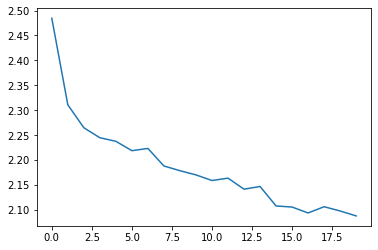

In [100]:
# loss plot (smoothed)

y = torch.tensor(list_loss).view(-1, 1000).mean(1).tolist()

sns.lineplot(x=range(len(y)), y=y)

### Evaluation

In [15]:
@torch.no_grad()
def eval(x_eval, y_eval):
    logits = model(x_eval, train=False)
    loss = torch.nn.functional.cross_entropy(logits, y_eval)
    return loss.item()


print(f"train={eval(X_TRAIN, Y_TRAIN)} \n valid={eval(X_VALID, Y_VALID)} \n test={eval(X_TEST, Y_TEST)}")


train=2.05883526802063 
 valid=2.09456729888916 
 test=2.0942931175231934


In [16]:
sum([p.nelement() for p in parameters]) / X_TRAIN.shape[0]

0.12099657768651609

In [17]:
# Generating New Names

def get_new_names_with_nn(n):
    names = []
    for _ in range(n):
        out = []
        block = [0] * NUM_OF_PREV_CHAR_TO_USE
        while True:
            temp_x = torch.tensor([block])
            logits = model(temp_x, train=False)
            probs = torch.nn.functional.softmax(logits)
            ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
            block = [*block[1:], ix]
            out.append(ix)
            if ix == 0:
                break
        names.append(''.join(itos[i] for i in out[:-1]))
    return names

get_new_names_with_nn(10)

/var/folders/81/p29glqk579jc_zzy2qdvx0g80000gn/T/ipykernel_36057/666770995.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(logits)


['junide',
 'janasia',
 'prefay',
 'adiya',
 'jirrito',
 'cossaree',
 'kalinaa',
 'zamileaha',
 'khedainr',
 'amells']

# Graveyard

In [50]:
X_TRAIN.shape

torch.Size([182625, 8])

In [41]:
# example
ix = torch.randint(low=0, high=X_TRAIN.shape[0], size=(4,))
xb, yb = X_TRAIN[ix], Y_TRAIN[ix]
logits = model(xb, train=False)
print(xb.shape, logits.shape)
print(xb)

torch.Size([4, 8]) torch.Size([4, 27])
tensor([[ 0,  0,  0, 19,  5, 14,  1,  9],
        [ 0,  0,  0,  0,  0,  2,  5,  3],
        [ 0,  0,  0,  0,  0,  0,  0, 14],
        [21,  2, 18,  5,  5, 12, 25, 14]])


In [55]:
test = torch.randint(0, 20, (2, 8, 10))
test

tensor([[[ 4,  1, 17,  9,  4,  4,  4,  1,  3,  9],
         [17,  7,  1, 15,  6, 19,  0, 17, 17,  2],
         [ 0,  3,  5,  2,  0, 16, 18,  3, 10,  2],
         [ 8,  7, 15,  0, 16, 13,  5,  4, 17,  7],
         [10, 11,  7, 17, 13,  5,  1, 18, 18, 17],
         [ 2, 13,  0,  7,  7, 19,  8, 10,  5, 10],
         [13, 15, 10,  5,  1, 15, 13, 10,  3, 16],
         [ 6, 17, 16,  7,  0,  6, 13, 14, 15, 17]],

        [[15,  3, 11, 10,  7, 11, 15, 11, 15,  6],
         [ 8, 16,  8, 16,  4,  9, 12,  6, 19,  4],
         [18, 11,  2, 19, 10,  8, 10,  8, 10,  1],
         [13, 19,  4,  4, 16, 13,  3,  5, 16,  3],
         [14,  9, 12,  8,  8, 14, 13,  3, 11, 13],
         [15, 17, 18, 19,  1, 17, 13, 15,  3, 11],
         [ 6, 11, 18,  7, 10, 12, 10,  6,  6,  4],
         [18,  2,  9, 11, 19, 19, 16,  7,  0,  5]]])

In [58]:
torch.cat([test[:, ::2, :], test[:, 1::2, :]], dim=2)

tensor([[[ 4,  1, 17,  9,  4,  4,  4,  1,  3,  9, 17,  7,  1, 15,  6, 19,  0,
          17, 17,  2],
         [ 0,  3,  5,  2,  0, 16, 18,  3, 10,  2,  8,  7, 15,  0, 16, 13,  5,
           4, 17,  7],
         [10, 11,  7, 17, 13,  5,  1, 18, 18, 17,  2, 13,  0,  7,  7, 19,  8,
          10,  5, 10],
         [13, 15, 10,  5,  1, 15, 13, 10,  3, 16,  6, 17, 16,  7,  0,  6, 13,
          14, 15, 17]],

        [[15,  3, 11, 10,  7, 11, 15, 11, 15,  6,  8, 16,  8, 16,  4,  9, 12,
           6, 19,  4],
         [18, 11,  2, 19, 10,  8, 10,  8, 10,  1, 13, 19,  4,  4, 16, 13,  3,
           5, 16,  3],
         [14,  9, 12,  8,  8, 14, 13,  3, 11, 13, 15, 17, 18, 19,  1, 17, 13,
          15,  3, 11],
         [ 6, 11, 18,  7, 10, 12, 10,  6,  6,  4, 18,  2,  9, 11, 19, 19, 16,
           7,  0,  5]]])

In [42]:
# embedding
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [43]:
# flatten
model.layers[1].out.shape

torch.Size([4, 80])

In [44]:
# linear
model.layers[2].out.shape

torch.Size([4, 200])

In [45]:
# batchnorm
model.layers[3].out.shape

torch.Size([4, 200])

In [46]:
# tanh
model.layers[4].out.shape

torch.Size([4, 200])

In [47]:
# second linear
model.layers[5].out.shape

torch.Size([4, 27])